<a href="https://colab.research.google.com/github/AleksandrMac/learning/blob/main/ai/hw/20_4_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

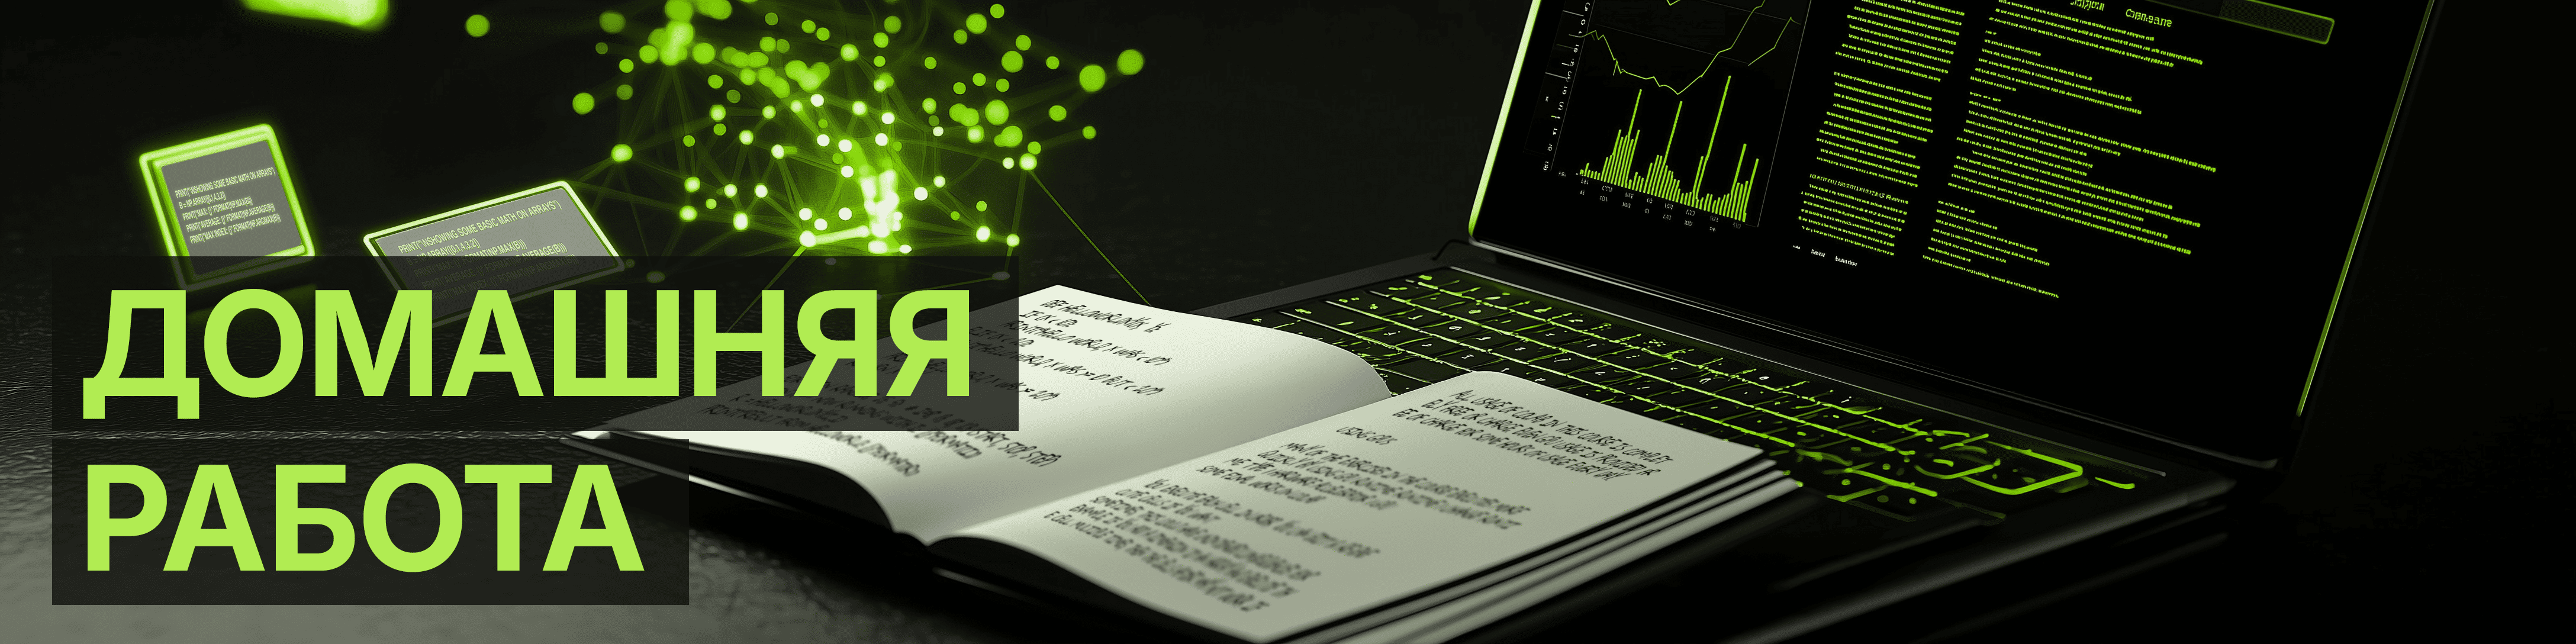

**Навигация по уроку**

1. [Обработка текстов с помощью нейронных сетей](https://colab.research.google.com/drive/1tPZPtZsEi4rv4J_4tcOBMDgyUNQDYKCX)
2. [Сравнение архитектур нейронных сетей для обработки текста](https://colab.research.google.com/drive/1KEFUgyBcqGaXGZEU-7MHENn5RH_AIvfH)
3. [Предварительно обученные векторные представления](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP)
4. Домашняя работа

В домашней работе необходимо выполнить следующее задание:

1. Подготовьте датасет с [писателями Русской литературы](https://storage.yandexcloud.net/academy.ai/russian_literature.zip) для обучения модели `Embedding` по аналогии с уроком [20.2](https://colab.research.google.com/drive/1KEFUgyBcqGaXGZEU-7MHENn5RH_AIvfH)
2. Подгрузите веса Наташи как в уроке [20.3](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP) для эмбендинга.
3. Заморозьте слой эмбединга.
4. Выберите любых 5 писателей и обучите модель на них, не забудьте про балансировку (предварительно выделите 10% датасета на проверочную выборку и 10% на тестовую). Выбирайте писателей с большими объемами текстов, что даст большее число примеров для обучения.
5. Добейтесь средней точности более 70% на тестовых образцах. Получите 3 балла.
6. Если сможете добиться точности более 85% получите 4 балла.
7. Хотите 5 баллов независимо от точности? Изучите самостоятельно и примените токенизатор [Razdel](https://github.com/natasha/razdel#usage) для данной задачи, вместо встроенного токенизатора для Keras.

**Подсказка**. Так как проверка задания проводиться по средней точности на тестовых образцах (вычисляем по диагонали матрицы ошибок), то для улучшения данного показателя используйте колбэк функцию `keras.callbacks.ModelCheckpoint` из урока [19.2](https://colab.research.google.com/drive/1x2qd4MvG3ODgNrE2uqxRAZB70dGgdGft) для сохранения лучшей эпохи.

**Подсказка 2**. Часто при работе с текстовыми данными вы можете заметить, что при использовании параметра `validation_split`, в методе `fit()`, точность на проверочной выборке ведет себя странно. В этом случае выделите проверочную выборку самостоятельно и используйте ее с помощью параметра `validation_data`.

In [1]:
# Загрузка предобученных Embedding
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2025-12-22 09:36:36--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.9MB/s    in 4.3s    

2025-12-22 09:36:41 (11.8 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [2]:
!pip install navec

In [3]:
from navec import Navec

navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

# 1. Подготовка датасета

In [4]:
import keras
data_path = keras.utils.get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip"
)

21547079/21547079 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "{data_path}" -d ./dataset

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Ф╨╛╨║╨╗╨░╨┤, ╨┐╤А╨╕╨│╨╛╤В╨╛╨▓╨╗╨╡╨╜╨╜╤Л╨╣ ╨┤╨╗╤П ╨║╨╛╨╜╨│╤А╨╡╤Б╤Б╨░ ╨╛ ╨╝╨╕╤А╨╡ ╨▓ ╨б╤В╨╛╨║╨│╨╛╨╗╤М╨╝╨╡.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Я╨╛╤З╨╡╨╝╤Г ╤Е╤А╨╕╤Б╤В╨╕╨░╨╜╤Б╨║╨╕╨╡ ╨╜╨░╤А╨╛╨┤╤Л ╨▓╨╛╨╛╨▒╤Й╨╡ ╨╕ ╨▓ ╨╛╤Б╨╛╨▒╨╡╨╜╨╜╨╛╤Б╤В╨╕ ╤А╤Г╤Б╤Б╨║╨╕╨╣ ╨╜╨░╤Е╨╛╨┤╤П╤В╤Б╤П ╤В╨╡╨┐╨╡╤А╤М ╨▓ ╨▒╨╡╨┤╤Б╤В╨▓╨╡╨╜╨╜╨╛╨╝ ╨┐╨╛╨╗╨╛╨╢╨╡╨╜╨╕╨╕.txt
        File name too long


**формирование датасета**

Отберем для обучения 5 произвольных писателей. Число токенов ограничим в 40 тыс. Предобученный эмбединг позволяет нам обучаться на малых выборках даже порядка нескольких тысяч слов.

In [6]:
CLASS_LIST=["Dostoevsky", "Tolstoy", "Chekhov", "Lermontov", "Pushkin"]

In [7]:
# Загрузка необходимых библиотек
import glob # Вспомогательный модуль для работы с файловой системой

all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
    all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
    for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
        with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
            # Загрузка содержимого файла в строку
            text = f.read()

        all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

**токенизация**

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 10000      # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', char_level=False)

print(all_texts["Tolstoy"][:1000])
# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

 Л. Н. Толстой МЕТЕЛЬ. РАССКАЗ. (1856) I.     В седьмом часу вечера, я, напившись чаю, выехал со станции, которой названия уже не помню, но помню, где-то в Земле Войска Донского, около Новочеркасска. Было уже темно, когда я, закутавшись в шубу и полость, рядом с Алешкой уселся в сани. За станционным домом казалось тепло и тихо. Хотя снегу не было сверху, над головой не виднелось ни одной звездочки, и небо казалось чрезвычайно низким и черным сравнительно с чистой снежной равниной, расстилавшейся впереди нас.  Едва миновав темные фигуры мельниц, из которых одна неуклюже махала своими большими крыльями, и выехав за станицу, я заметил, что дорога стала тяжелее и засыпаннее, ветер сильнее стал дуть мне в левую сторону, заносить в бок хвосты и гривы лошадей и упрямо поднимать и относить снег, разрываемый полозьями и копытами. Колокольчик стал замирать, струйка холодного воздуха пробежала через какое-то отверстие в рукаве за спину, и мне пришел в голову совет смотрителя не ездить лучше, чтоб

In [9]:
print(all_texts["Tolstoy"][:1000])

 Л. Н. Толстой МЕТЕЛЬ. РАССКАЗ. (1856) I.     В седьмом часу вечера, я, напившись чаю, выехал со станции, которой названия уже не помню, но помню, где-то в Земле Войска Донского, около Новочеркасска. Было уже темно, когда я, закутавшись в шубу и полость, рядом с Алешкой уселся в сани. За станционным домом казалось тепло и тихо. Хотя снегу не было сверху, над головой не виднелось ни одной звездочки, и небо казалось чрезвычайно низким и черным сравнительно с чистой снежной равниной, расстилавшейся впереди нас.  Едва миновав темные фигуры мельниц, из которых одна неуклюже махала своими большими крыльями, и выехав за станицу, я заметил, что дорога стала тяжелее и засыпаннее, ветер сильнее стал дуть мне в левую сторону, заносить в бок хвосты и гривы лошадей и упрямо поднимать и относить снег, разрываемый полозьями и копытами. Колокольчик стал замирать, струйка холодного воздуха пробежала через какое-то отверстие в рукаве за спину, и мне пришел в голову совет смотрителя не ездить лучше, чтоб

**Преобразование текста в последовательность**

In [10]:
seq_train = tokenizer.texts_to_sequences(all_texts.values())

In [11]:
print(seq_train[0][:1000])

[150, 3, 389, 54, 4, 265, 187, 2, 1129, 9841, 108, 389, 33, 22, 4193, 314, 57, 223, 57, 4, 17, 7514, 8592, 55, 1050, 1140, 11, 2535, 79, 6, 1018, 1524, 5303, 1, 52, 4638, 12, 75, 3796, 144, 2030, 2, 135, 7, 3796, 144, 28, 181, 1707, 2, 1, 5303, 8, 2, 8215, 1, 3970, 4281, 1, 7833, 2, 818, 1, 22, 1, 1189, 3971, 548, 1, 15, 2077, 181, 28, 217, 1189, 23, 1186, 1, 2, 1515, 1, 19, 7833, 144, 9, 5381, 32, 755, 3141, 4690, 4752, 876, 1438, 755, 1438, 307, 141, 4007, 28, 1404, 3000, 451, 15, 1, 580, 6079, 3201, 2, 1119, 2720, 1473, 3, 818, 5, 2894, 22, 533, 1747, 141, 4824, 11, 164, 8216, 30, 1, 462, 120, 1375, 224, 15, 11, 873, 922, 272, 5, 2432, 4008, 36, 830, 445, 227, 406, 1060, 1176, 2138, 136, 622, 6944, 1, 17, 134, 1852, 1, 431, 163, 1852, 46, 2084, 17, 43, 4, 25, 174, 91, 129, 1, 4393, 3, 102, 3, 10, 105, 68, 5, 12, 15, 6, 4231, 7337, 452, 81, 125, 4, 84, 12, 4691, 79, 66, 532, 44, 1708, 5008, 59, 193, 134, 1, 8217, 8, 7515, 172, 15, 8218, 30, 5382, 122, 7, 438, 408, 431, 198, 574, 1, 1

**Балансировка датасета**

In [12]:
seq_train_balance = [seq_train[cls][:40000] for cls in range(len(CLASS_LIST))]

In [13]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train_balance)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 200000 слов


In [14]:
import numpy as np

print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Dostoevsky - 40000 слов, доля в общей базе: 20.00%
Tolstoy - 40000 слов, доля в общей базе: 20.00%
Chekhov - 40000 слов, доля в общей базе: 20.00%
Lermontov - 40000 слов, доля в общей базе: 20.00%
Pushkin - 40000 слов, доля в общей базе: 20.00%
Среднее значение слов:  40000.0
Медианное значение слов:  40000.0


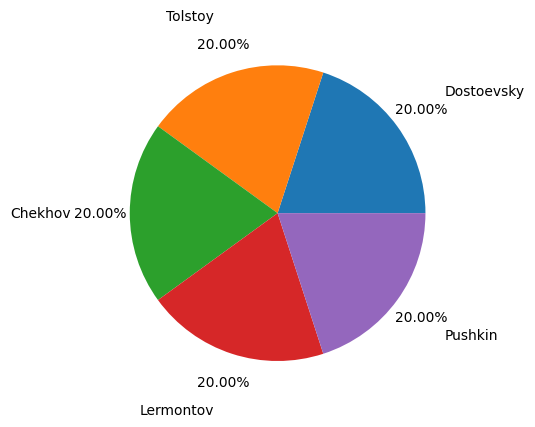

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

**Нарезка примеров из текста методом скользящего окна**

In [16]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую сборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test =  [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1-test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step) # последовательность до порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][gate_split:], win_size, step)  # последовательность после порога попадет в тестовую выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_test)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [17]:
x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST, WIN_SIZE, WIN_STEP)

In [18]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (1755, 1000)
Форма выходных данных (меток) для обучающей выборки: (1755, 5)


In [19]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (155, 1000)
Форма выходных данных (меток) для тестовой выборки: (155, 5)


**Определим вспомогательные функции**

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок

# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# 2. Загрузка весов

In [21]:
import numpy as np

word_index = tokenizer.word_index
embeddings_index = navec

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# 3. Архитектура сети(embedding)

In [22]:
from keras.models import Sequential
from keras.layers import Input, Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout

model = Sequential()
model.add(Input(shape=(WIN_SIZE,)))
model.add(Embedding(max_words, embedding_dim, weights=embedding_matrix))
model.add(BatchNormalization())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(CLASS_LIST), activation='softmax'))

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 300)      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 300)      │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000, 40)       │        12,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1000, 40)       │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │       200,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,213,405 (12.26 MB)

 Trainable params: 3,212,725 (12.26 MB)

 Non-trainable params: 680 (2.66 KB)

In [23]:
model.layers[0].trainable = False

# 4. Обучение

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.1)
model.save_weights('pre_trained_model.weights.h5') # можно сохранять не только модели, но и веса

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 531ms/step - accuracy: 0.2727 - loss: 2.1155 - val_accuracy: 0.0000e+00 - val_loss: 3.2605
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 517ms/step - accuracy: 0.8561 - loss: 0.3475 - val_accuracy: 0.0000e+00 - val_loss: 8.6869
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 526ms/step - accuracy: 0.9633 - loss: 0.0997 - val_accuracy: 0.0000e+00 - val_loss: 12.9522
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 518ms/step - accuracy: 0.9778 - loss: 0.0608 - val_accuracy: 0.0000e+00 - val_loss: 15.1377
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 581ms/step - accuracy: 0.9967 - loss: 0.0259 - val_accuracy: 0.0000e+00 - val_loss: 15.9985
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step - accuracy: 0.9899 - loss: 0.0269 - val_accuracy: 0.0000e+00 - val_loss: 16.0119
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 515ms/step - accuracy: 0.9956 - loss: 0.0167 - val_accuracy: 0.0000e+00 - val_loss: 15.1014
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 512ms/step - accuracy:

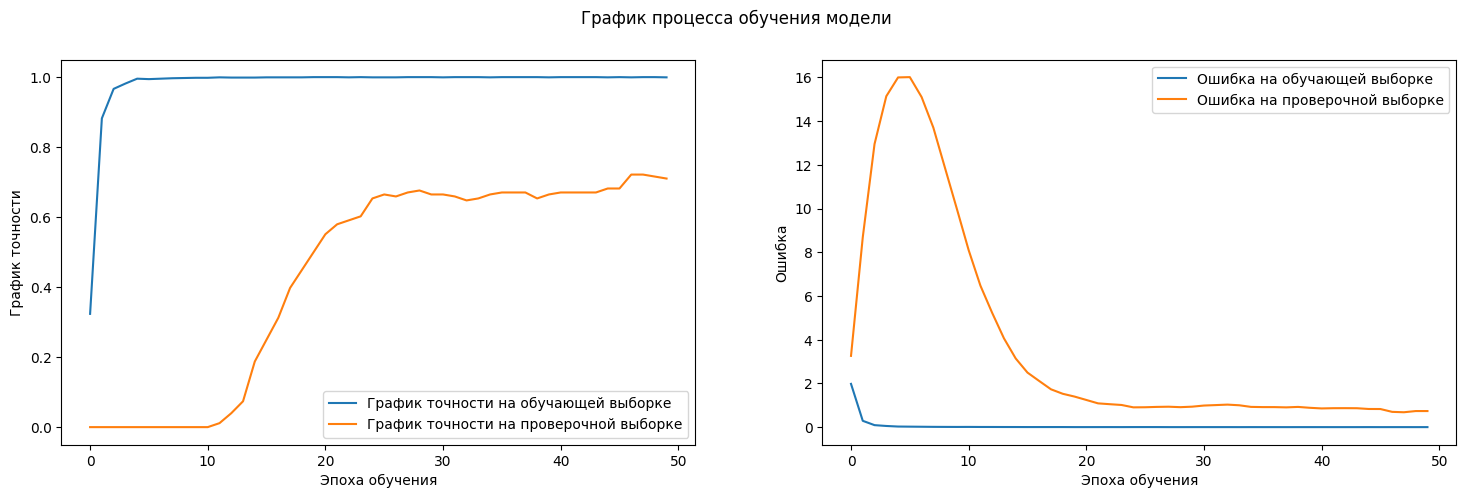

In [25]:
show_plot(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


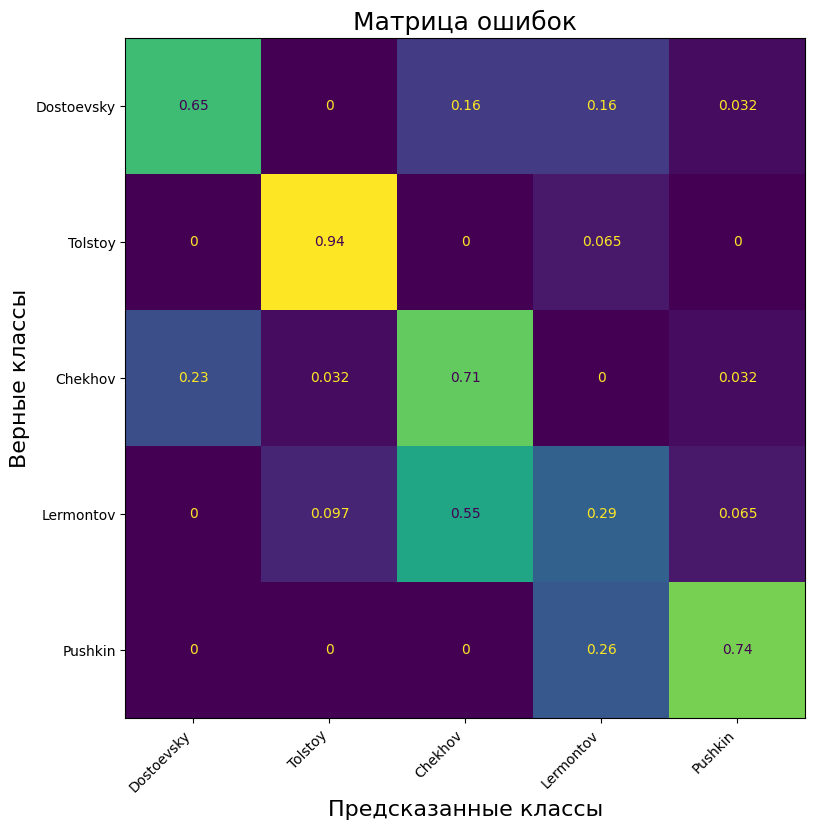


Средняя точность распознавания:  66%


In [26]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)

In [27]:
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 576ms/step - accuracy: 1.0000 - loss: 6.1561e-04 - val_accuracy: 0.7045 - val_loss: 0.7454
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 515ms/step - accuracy: 1.0000 - loss: 4.9285e-04 - val_accuracy: 0.7045 - val_loss: 0.7622
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 515ms/step - accuracy: 1.0000 - loss: 4.7041e-04 - val_accuracy: 0.7045 - val_loss: 0.7654
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 516ms/step - accuracy: 1.0000 - loss: 6.6398e-04 - val_accuracy: 0.6989 - val_loss: 0.7935
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 527ms/step - accuracy: 1.0000 - loss: 1.7872e-04 - val_accuracy: 0.6989 - val_loss: 0.7979
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 526ms/step - accuracy: 1.0000 - loss: 2.9517e-04 - val_accuracy: 0.6989 - val_loss: 0.7729
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 527ms/step - accuracy: 1.0000 - loss: 3.8924e-04 - val_accuracy: 0.7159 - val_loss: 0.7327
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - accuracy: 1.00

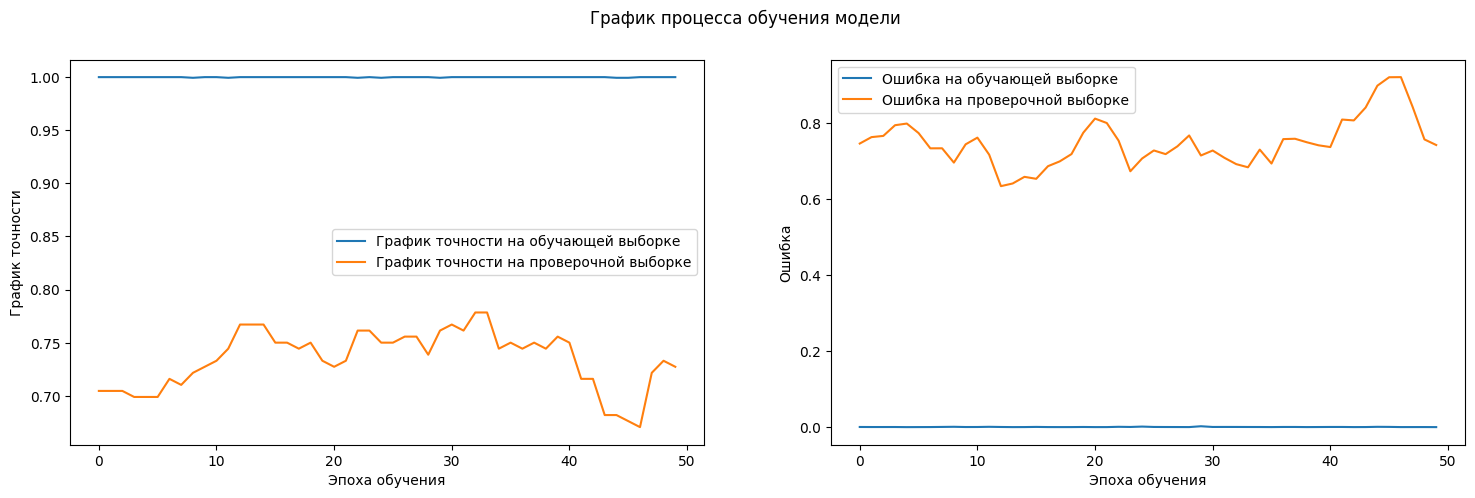

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


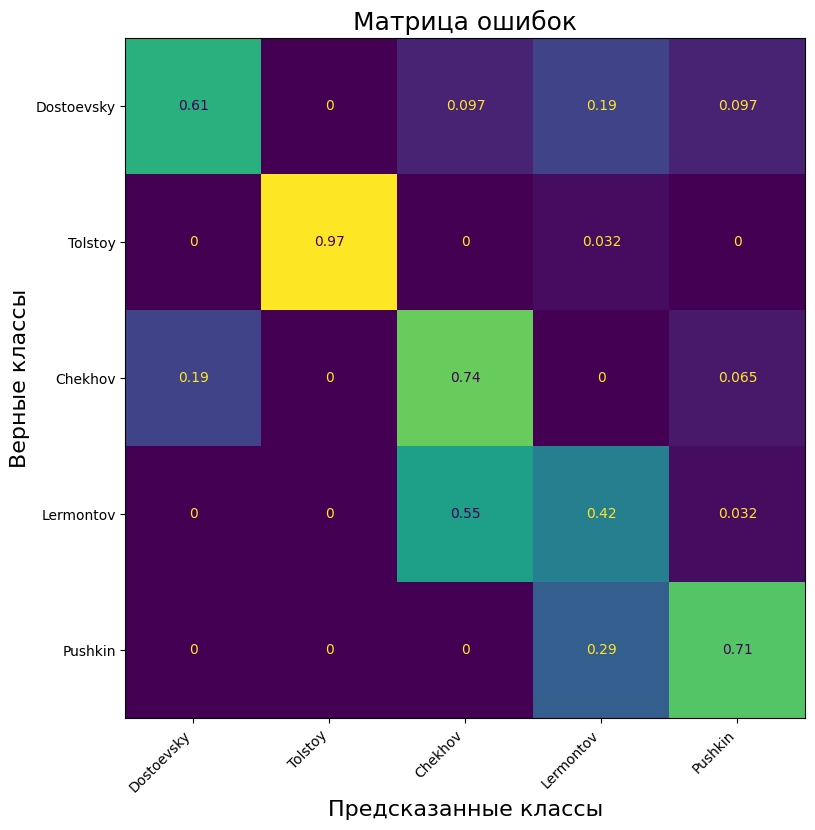


Средняя точность распознавания:  69%


In [28]:
show_plot(history)
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)

In [29]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 647ms/step - accuracy: 1.0000 - loss: 8.7365e-04 - val_accuracy: 0.7216 - val_loss: 0.7808
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 552ms/step - accuracy: 1.0000 - loss: 3.3412e-04 - val_accuracy: 0.7102 - val_loss: 0.8572
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 519ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.7443 - val_loss: 0.7302
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 518ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.7670 - val_loss: 0.6624
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 505ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.7841 - val_loss: 0.5330
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 519ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8409 - val_loss: 0.4515
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 554ms/step - accuracy: 0.9996 - loss: 5.9870e-04 - val_accuracy: 0.8182 - val_loss: 0.5188
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 546ms/step - accuracy: 0.9999 - loss: 0.001

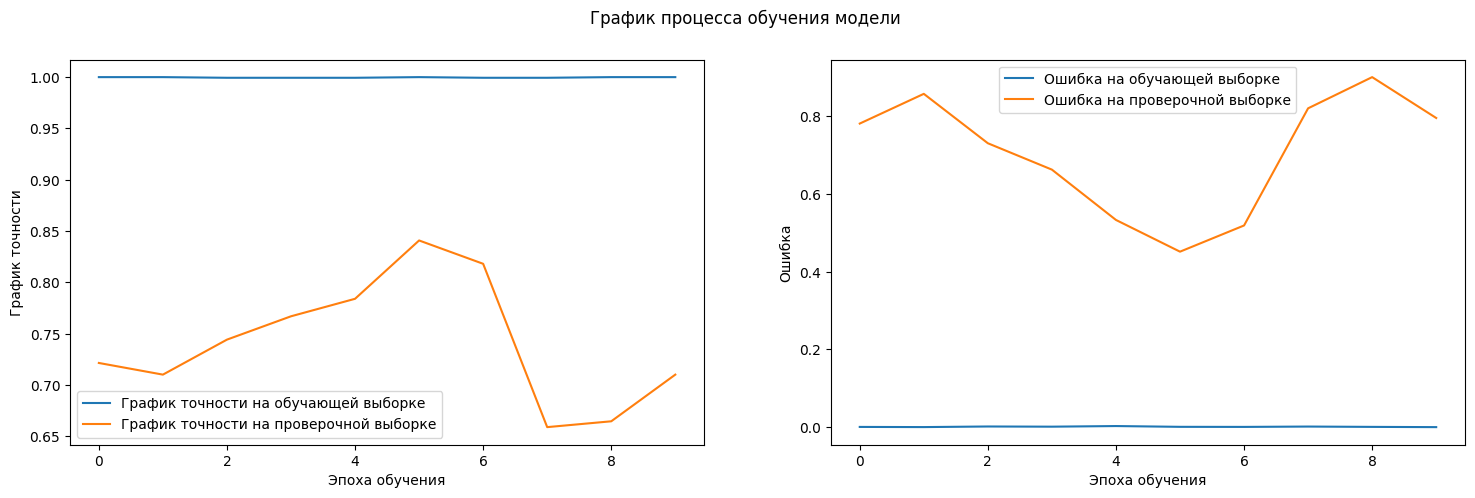

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


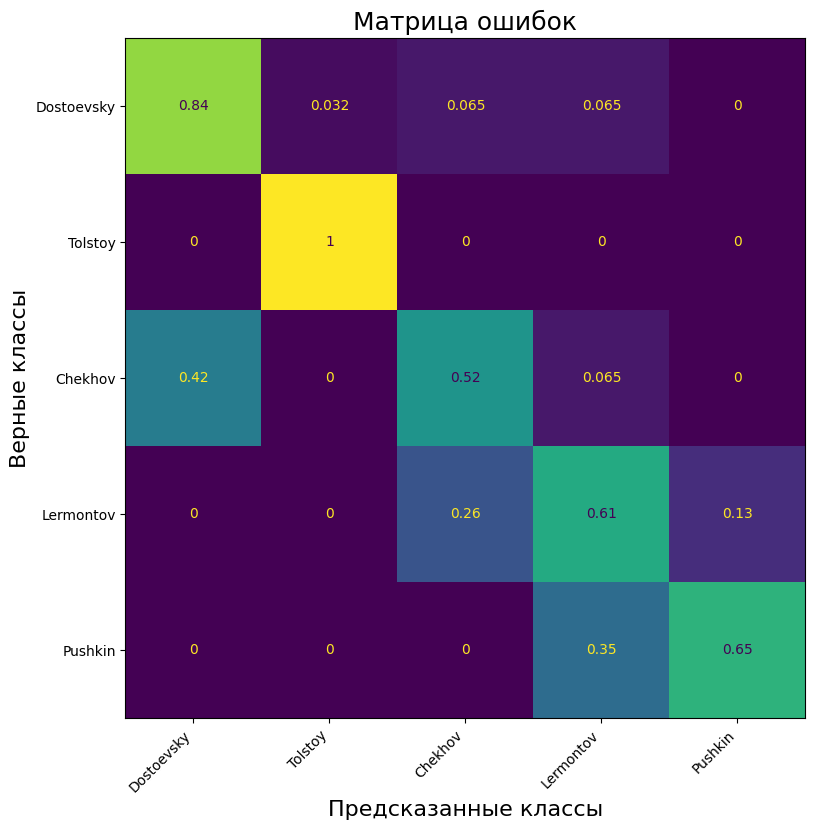


Средняя точность распознавания:  72%


In [30]:
show_plot(history)
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

In [32]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.7784 - val_loss: 0.5668
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 564ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.8750 - val_loss: 0.3306
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 547ms/step - accuracy: 0.9999 - loss: 8.9702e-04 - val_accuracy: 0.8295 - val_loss: 0.4208
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step - accuracy: 0.9994 - loss: 0.0013 - val_accuracy: 0.7670 - val_loss: 0.6345
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.7386 - val_loss: 0.8641
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 542ms/step - accuracy: 0.9941 - loss: 0.0078 - val_accuracy: 0.6193 - val_loss: 1.5173
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 540ms/step - accuracy: 0.9984 - loss: 0.0054 - val_accuracy: 0.7443 - val_loss: 0.7647
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step - accuracy: 0.9953 - loss: 0.0101 - val_

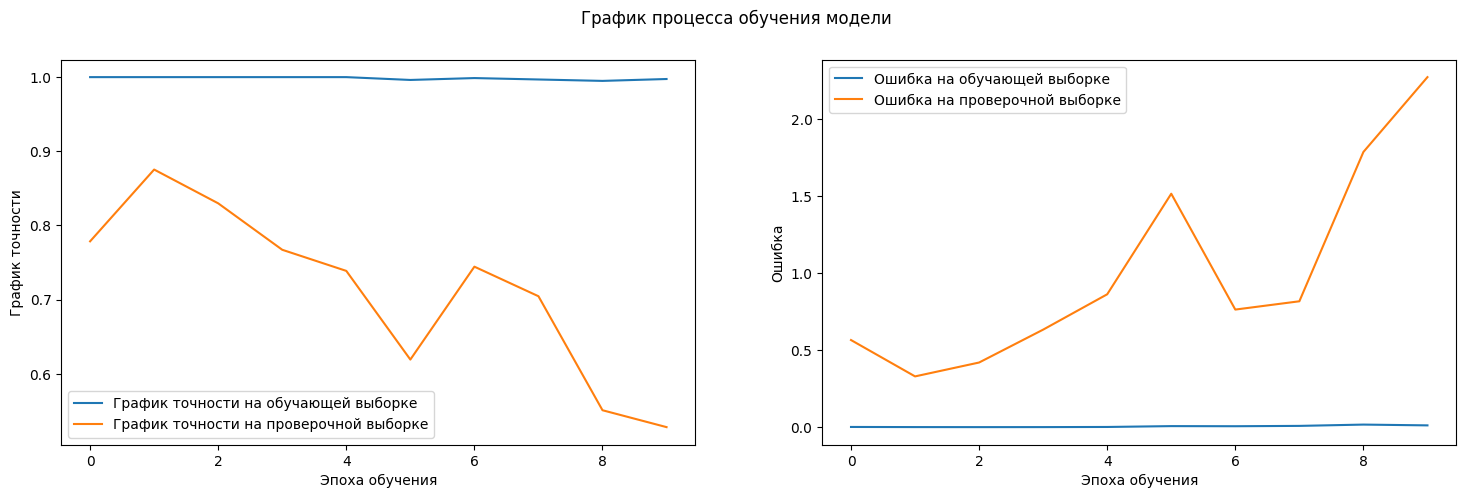

In [33]:
show_plot(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


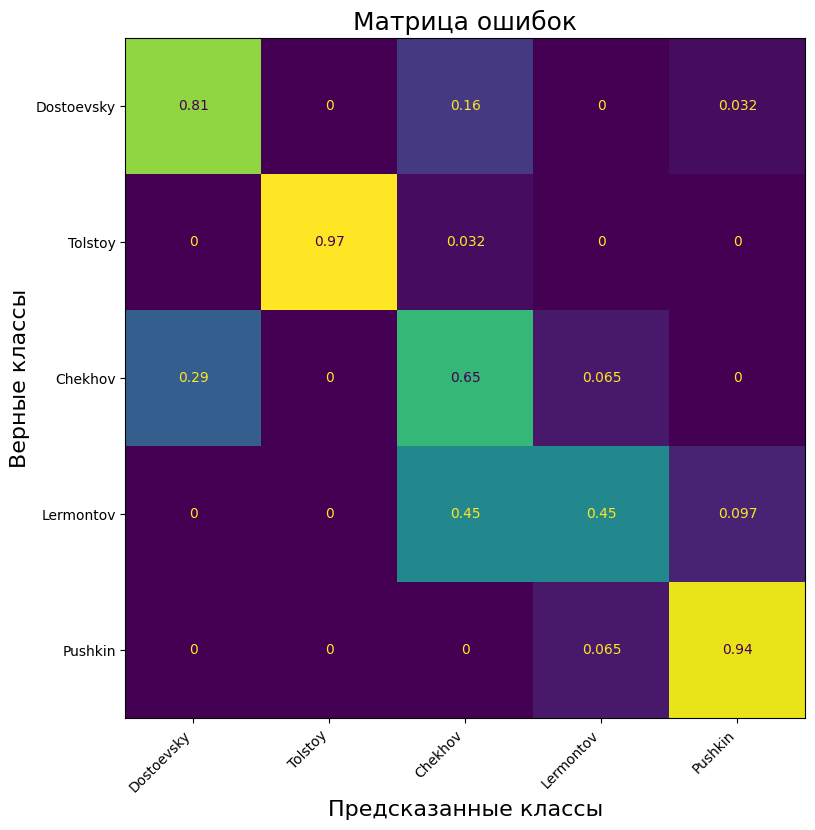


Средняя точность распознавания:  76%


In [34]:
from tensorflow.keras.models import load_model
r_model = load_model("best_model_pretrain.keras")

y_pred = r_model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)

In [35]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 544ms/step - accuracy: 0.9951 - loss: 0.0208 - val_accuracy: 0.5852 - val_loss: 1.9627
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 533ms/step - accuracy: 0.9927 - loss: 0.0220 - val_accuracy: 0.6250 - val_loss: 1.8575
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step - accuracy: 0.9926 - loss: 0.0333 - val_accuracy: 0.6477 - val_loss: 1.6286
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.9931 - loss: 0.0181 - val_accuracy: 0.7273 - val_loss: 1.3314
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 533ms/step - accuracy: 0.9901 - loss: 0.0266 - val_accuracy: 0.7102 - val_loss: 2.1653
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.9936 - loss: 0.0172 - val_accuracy: 0.7727 - val_loss: 1.5070
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step - accuracy: 0.9948 - loss: 0.0227 - val_accuracy: 0.7386 - val_loss: 1.6140
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 533ms/step - accuracy: 0.9920 - loss: 0.0421 - val_accu

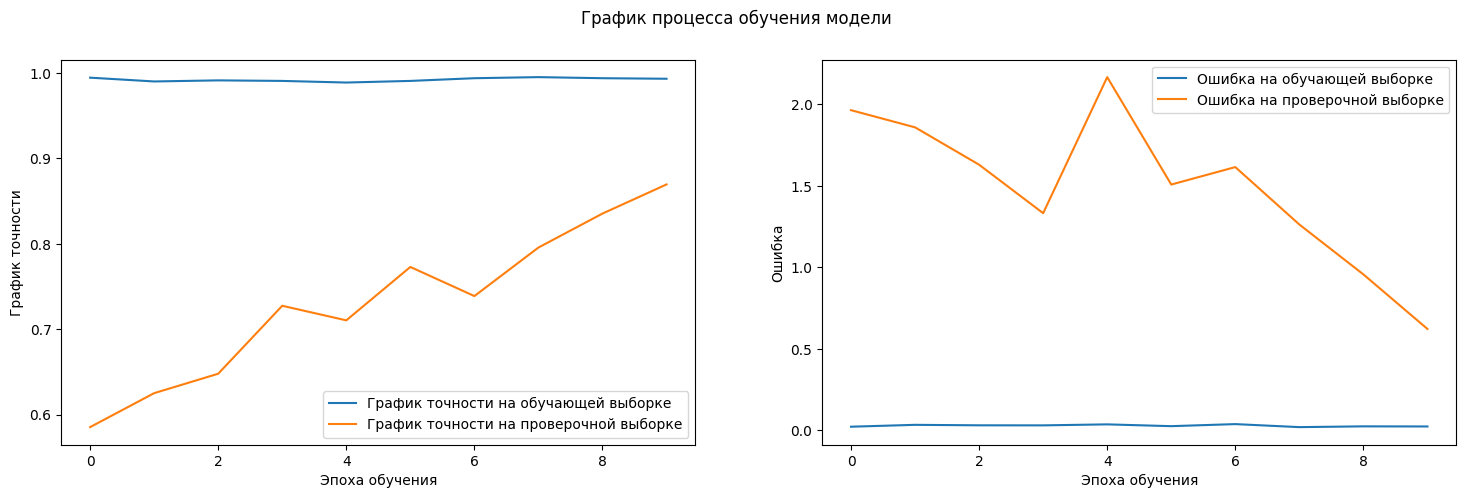

In [36]:
show_plot(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


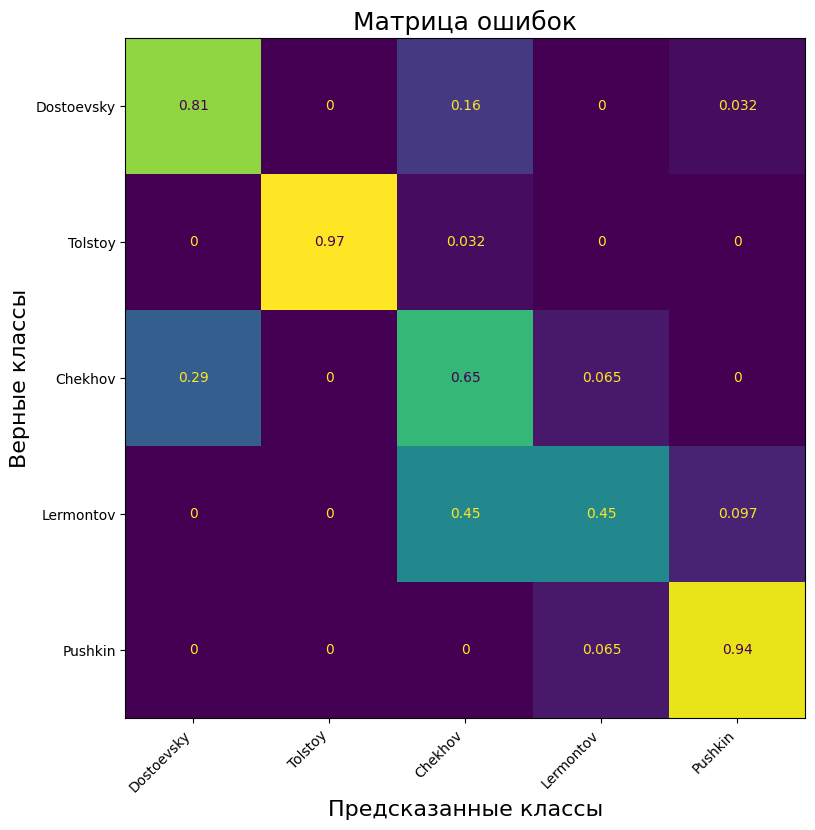


Средняя точность распознавания:  76%


In [37]:
y_pred = r_model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 531ms/step - accuracy: 0.9967 - loss: 0.0056 - val_accuracy: 0.8807 - val_loss: 0.7441
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 527ms/step - accuracy: 0.9930 - loss: 0.0375 - val_accuracy: 0.9148 - val_loss: 0.4733
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step - accuracy: 0.9929 - loss: 0.0193 - val_accuracy: 0.9205 - val_loss: 0.3939
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 924ms/step - accuracy: 0.9982 - loss: 0.0108 - val_accuracy: 0.8182 - val_loss: 0.9653
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - accuracy: 0.9971 - loss: 0.0052 - val_accuracy: 0.8125 - val_loss: 0.9990
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 531ms/step - accuracy: 0.9949 - loss: 0.0238 - val_accuracy: 0.7557 - val_loss: 1.3858
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 530ms/step - accuracy: 0.9965 - loss: 0.0121 - val_accuracy: 0.7330 - val_loss: 1.5495
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - accuracy: 1.0000 - loss: 2.8181e-04 - val_

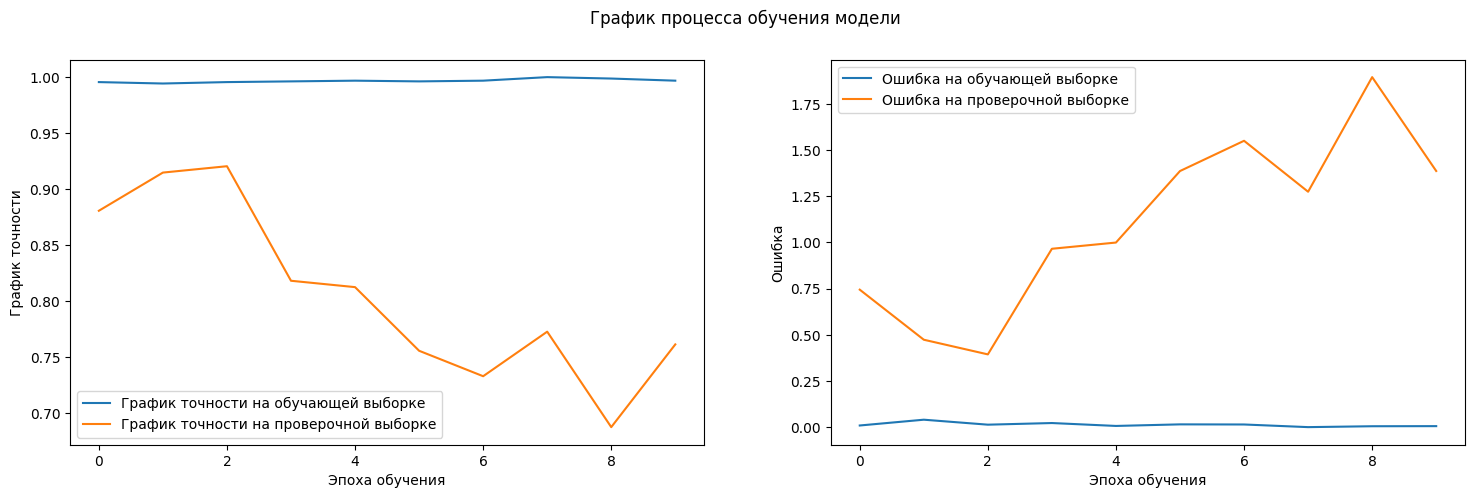

In [38]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=callbacks)
show_plot(history)

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


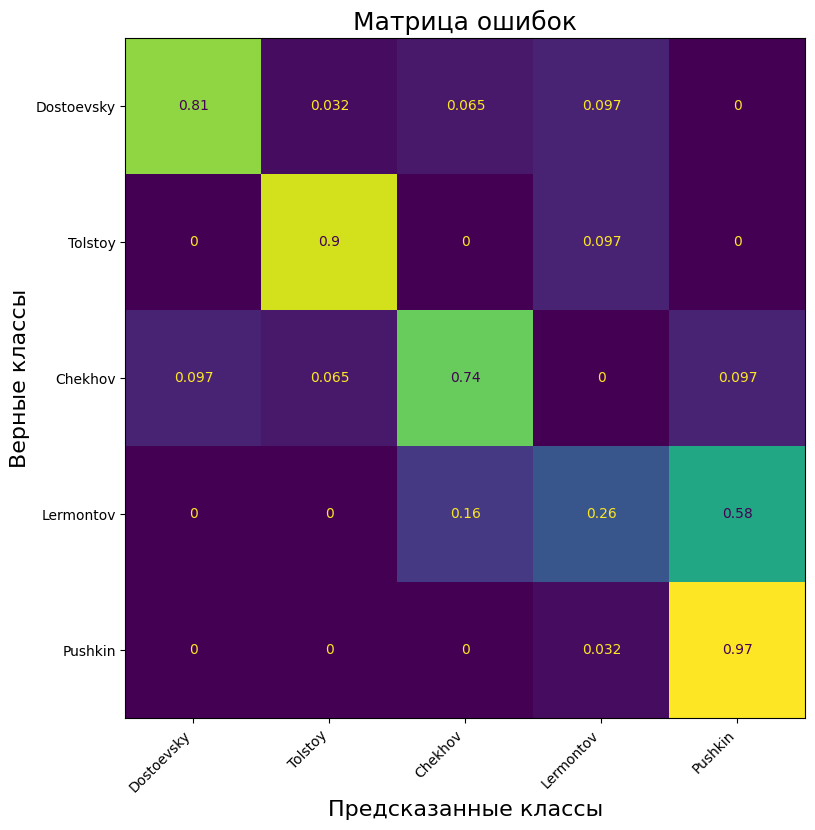


Средняя точность распознавания:  74%


In [40]:
from tensorflow.keras.models import load_model
r_model = load_model("best_model_pretrain.keras")

y_pred = r_model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 557ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.7386 - val_loss: 1.8116
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 581ms/step - accuracy: 0.9985 - loss: 0.0069 - val_accuracy: 0.7670 - val_loss: 1.4971
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 526ms/step - accuracy: 0.9983 - loss: 0.0018 - val_accuracy: 0.7955 - val_loss: 1.1205
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 526ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.8295 - val_loss: 0.7790
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 527ms/step - accuracy: 0.9995 - loss: 7.8761e-04 - val_accuracy: 0.8125 - val_loss: 0.8845
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step - accuracy: 0.9960 - loss: 0.0166 - val_accuracy: 0.8466 - val_loss: 0.7263
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 532ms/step - accuracy: 0.9998 - loss: 8.5483e-04 - val_accuracy: 0.7898 - val_loss: 1.0084
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 530ms/step - accuracy: 0.9973 - loss: 0.0041 - 

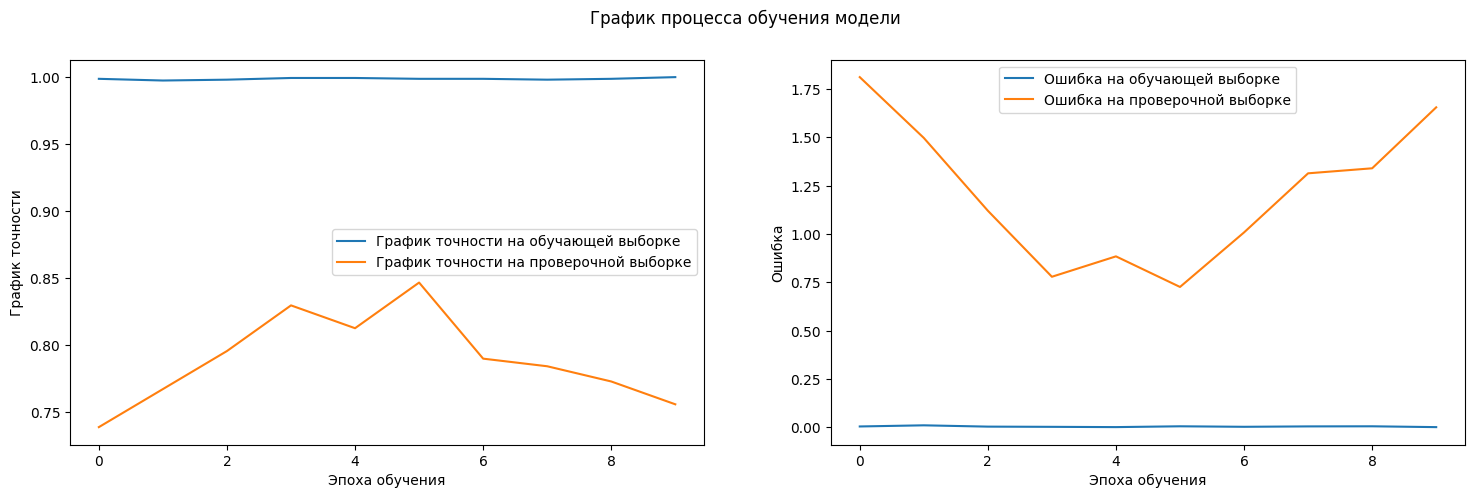

In [41]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=callbacks)
show_plot(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


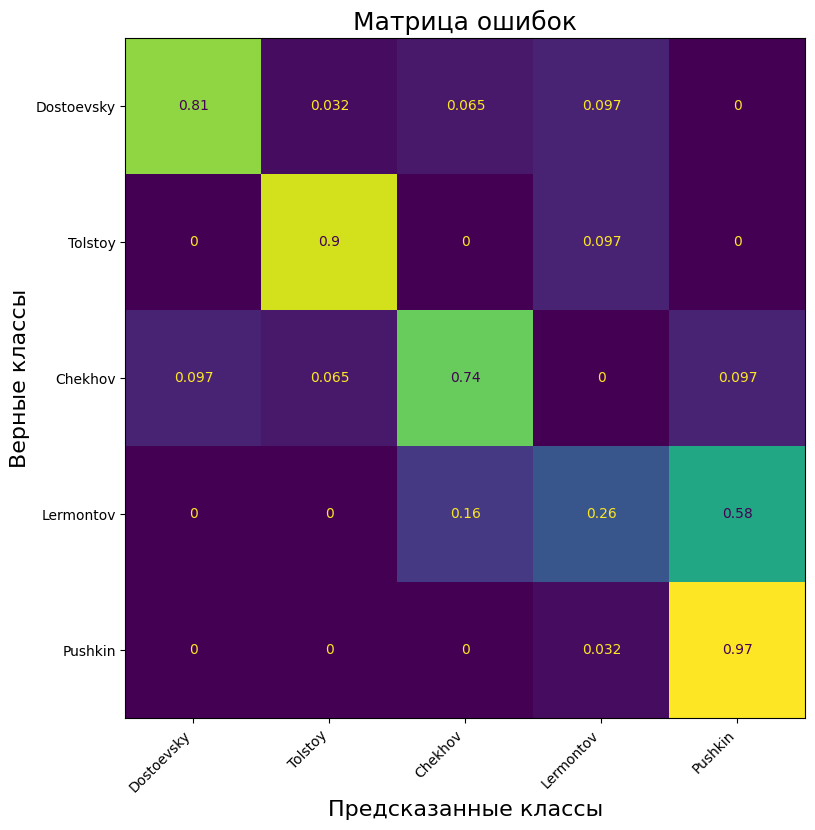


Средняя точность распознавания:  74%


In [42]:
from tensorflow.keras.models import load_model
r_model = load_model("best_model_pretrain.keras")

y_pred = r_model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST)

при использовании примера из урока, получается улучшать результаты обучания при увеличении количества эпох. обучение идет скачками, но даже спустя 130 эпох наблюдался положительный тренд. однако далее уже сложнее. хотя и можно еще попробовать.